In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
batch_size = 64
learning_rate = 0.001

In [ ]:
train_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/datasets/cifar10',
                                 train=True,
                                 transform=train_trans,
                                 download=True
                                 )

test_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/datasets/cifar10',
                                 train=False,
                                 transform=val_trans,
                                download=True
                                 )

val_dataset, test_dataset = torch.utils.data.random_split(test_dataset,
                    [int(0.9*len(test_dataset)), int(0.1*len(test_dataset))])

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


Extracting /content/drive/MyDrive/datasets/cifar10/cifar-10-python.tar.gz to /content/drive/MyDrive/datasets/cifar10
Files already downloaded and verified


In [ ]:
class conv_block (nn.Module):
    def __init__ (self, in_channels, out_channels, kernel_size, stride, padding):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                              padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.relu(self.bn(self.conv(X)))

        return out

class inception_block (nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5,
                 out_5x5, pool_1x1):
        super(inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1,
                                  kernel_size=(1,1),
                                  stride=(1,1),
                                  padding=(0,0))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1,1),
                       stride=(1,1), padding=(0,0)),
            conv_block(red_3x3, out_3x3, kernel_size=(3,3),
                       stride=(1,1), padding=(1,1))
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1),
                       stride=(1, 1), padding=(0, 0)),
            conv_block(red_5x5, out_5x5, kernel_size=(3, 3),
                       stride=(1, 1), padding=(1, 1))
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            conv_block(in_channels, pool_1x1, kernel_size=(1, 1),
                       stride=(1, 1), padding=(0, 0))
        )

    def forward(self, X):

        return torch.cat([self.branch1(X),
                          self.branch2(X),
                          self.branch3(X),
                          self.branch4(X)], 1)


class InceptionAux (nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.pool = nn.AvgPool2d(kernel_size=(5,5), stride=(3,3),
                                 padding=(0,0))

        self.conv = conv_block(in_channels=in_channels,
                               out_channels=128,
                               kernel_size=(1,1),
                               stride=(1,1),
                               padding=(0,0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.fc1 = nn.Linear(in_features=2048,  out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, X):

        out = self.pool(X)
        out = self.conv(out)

        out = out.reshape(out.shape[0], -1)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

class GoogleNet (nn.Module):
    def __init__(self, in_channels, num_classes, use_aux=False):
        super(GoogleNet, self).__init__()
        assert use_aux == True or use_aux == False
        self.use_aux = use_aux
        self.conv1 = conv_block(in_channels=in_channels,
                              out_channels=64,
                              kernel_size=(7,7),
                              stride=(2,2),
                              padding=(3,3))

        self.pool = nn.MaxPool2d(kernel_size=(3,3),
                                 stride=(2,2),
                                 padding=(1,1))

        self.conv2 = conv_block(in_channels=64,
                                out_channels=64,
                                kernel_size=(1,1),
                                stride=(1,1),
                                padding=(0,0))

        self.conv3 = conv_block(in_channels=64,
                                out_channels=192,
                                kernel_size=(3,3),
                                stride=(1,1),
                                padding=(1,1))

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)

        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)

        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1),
                                    padding=(0,0))
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(in_features=1024, out_features=num_classes)

        if self.use_aux:
            self.aux4a = InceptionAux(in_channels=512, num_classes=num_classes)
            self.aux4d = InceptionAux(in_channels=528, num_classes=num_classes)
        else:
            self.aux4a = self.aux4d = None


    def forward(self, X):

        out = self.conv1(X)
        out = self.pool(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.pool(out)

        out = self.inception3a(out)
        out = self.inception3b(out)
        out = self.pool(out)

        out = self.inception4a(out)

        if self.use_aux and self.training:
            aux1 = self.aux4a(out)

        out = self.inception4b(out)
        out = self.inception4c(out)
        out = self.inception4d(out)

        if self.use_aux and self.training:
            aux2 = self.aux4d(out)

        out = self.inception4e(out)
        out = self.pool(out)

        out = self.inception5a(out)
        out = self.inception5b(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        out = self.dropout(out)
        out = self.fc(out)

        if self.use_aux and self.training:
            return out, aux1, aux2
        else:
            return out

In [ ]:
model = GoogleNet(in_channels=3, num_classes=10, use_aux=True).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_loop (model, num_epochs, step_lr_scheduler, loss_train, loss_val, 
                train_acc_hist, val_acc_hist, best_acc
              ):

  for epoch in range(num_epochs):

      model.train()

      running_loss = 0.0
      running_corrects = 0

      # running_loss1 = 0.0
      # running_corrects1 = 0

      # running_loss2 = 0.0
      # running_corrects2 = 0

      for idx, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          z_score, z_score1, z_score2 = model(images)
          loss = criterion(z_score, labels)
          # loss1 = criterion(z_score1, labels)
          # loss2 = criterion(z_score2, labels)
          optimizer.zero_grad()
          loss.backward()
          # loss1.backward()
          # loss2.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predictions = torch.max(z_score, 1)
          running_corrects += torch.sum(predictions == labels)

          # running_loss1 += loss1.item() * images.size(0)
          # _, predictions1 = torch.max(z_score1, 1)
          # running_corrects1 += torch.sum(predictions1 == labels)

          # running_loss2 += loss2.item() * images.size(0)
          # _, predictions2 = torch.max(z_score2, 1)
          # running_corrects2 += torch.sum(predictions2 == labels)

      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset)
      print(f'Epoch {epoch+1} / {num_epochs}, '
            f'Train Loss {epoch_loss:.4f}, '
            f'Train Acc {epoch_acc:.4f}')
      
      # epoch_loss1 = running_loss1 / len(train_dataset)
      # epoch_acc1 = running_corrects1 / len(train_dataset)
      # print(f'Epoch {epoch+1} / {num_epochs}, '
      #       f'Train Loss {epoch_loss1:.4f}, '
      #       f'Train Acc {epoch_acc1:.4f}')
      
      # epoch_loss2 = running_loss2 / len(train_dataset)
      # epoch_acc2 = running_corrects2 / len(train_dataset)
      # print(f'Epoch {epoch+1} / {num_epochs}, '
      #       f'Train Loss {epoch_loss2:.4f}, '
      #       f'Train Acc {epoch_acc2:.4f}')

      train_acc_hist.append(epoch_acc)
      loss_train.append(epoch_loss)

      # train_acc_hist1.append(epoch_acc1)
      # loss_train1.append(epoch_loss1)

      # train_acc_hist2.append(epoch_acc2)
      # loss_train2.append(epoch_loss2)

      step_lr_scheduler.step()

      model.eval()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

          with torch.no_grad():
              z_scores = model(images)
              loss = criterion(z_scores, labels)

              running_loss += loss.item() * images.size(0)
              _, predictions = torch.max(z_scores, 1)
              running_corrects += torch.sum(predictions == labels)

      epoch_loss_val = running_loss / len(val_dataset)
      epoch_acc_val = running_corrects / len(val_dataset)
      print(f'Epoch {epoch + 1} / {num_epochs}, '
            f'Val Loss {epoch_loss_val:.4f}, '
            f'Val Acc {epoch_acc_val:.4f}')

      val_acc_hist.append(epoch_acc_val)
      loss_val.append(epoch_loss_val)

      if epoch_acc_val > best_acc:
          best_acc = epoch_acc_val

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
num_epochs = 3
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
# train_acc_hist1 = []
# val_acc_hist1 = []
# train_acc_hist2 = []
# val_acc_hist2 = []
best_acc = 0.0

In [ ]:
start = time.time()
train_loop(model, num_epochs, step_lr_scheduler, loss_train, loss_val, 
           train_acc_hist, val_acc_hist, best_acc
          )
time_elapsed = time.time() - start

Epoch 1 / 3, Train Loss 1.8409, Train Acc 0.3104
Epoch 1 / 3, Val Loss 1.8253, Val Acc 0.3259
Epoch 2 / 3, Train Loss 1.5325, Train Acc 0.4386
Epoch 2 / 3, Val Loss 1.7576, Val Acc 0.4084
Epoch 3 / 3, Train Loss 1.3239, Train Acc 0.5233
Epoch 3 / 3, Val Loss 1.5765, Val Acc 0.4883


In [ ]:
calculate_time(time_elapsed)

Training complete in 17m 40s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.0000


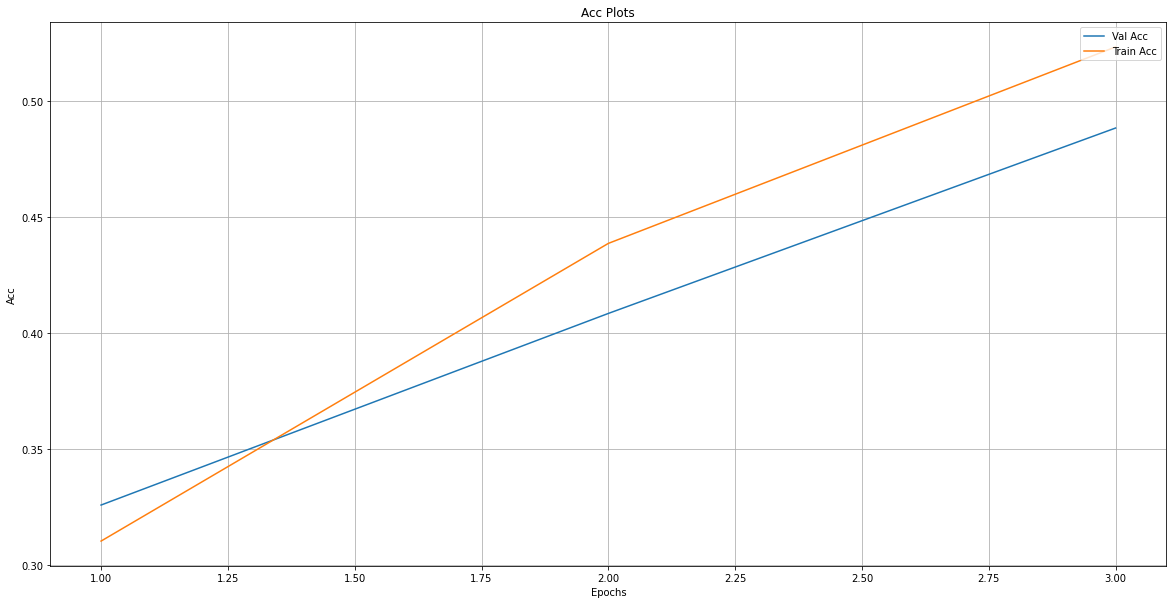

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

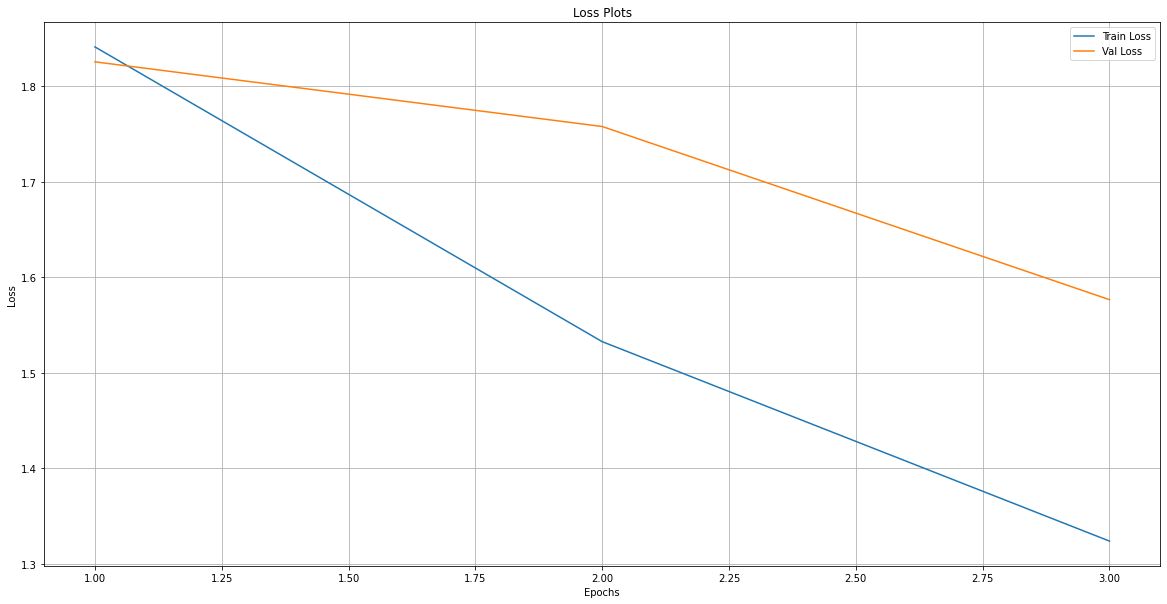

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.5000


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrivegooglenet_on_cifar.pth')

FileNotFoundError: ignored